## MazeExplorer dataset

In [1]:
from dataset import *
import random
random.seed(7)

### Create dataset instance

In [2]:
me = MazeExplorer(maze_size=(64,64), nbr_instances=100, 
                  difficulty='hard', nbr_trajectories=20,
                  alpha=1)

100%|██████████| 50/50 [00:00<00:00, 435.20it/s]

Creating MazeExplorer dataset of difficulty hard
Using Prims generator
Using shortest path solver



100%|██████████| 50/50 [00:00<00:00, 296.22it/s]


Dataset generated... 2200 available instances


### Plot examples

In [3]:
# Get one example from the dataset
grid = me[801][0]
path = me[801][1]
goal = me[801][2]
solution = me[801][3]
expert_flag = me[801][4]

pred_grid = predicted_grid(solution[4], 
                           estimate_road_width(grid), 64)                      

Text(0.5, 1.0, 'expert trajectory True')

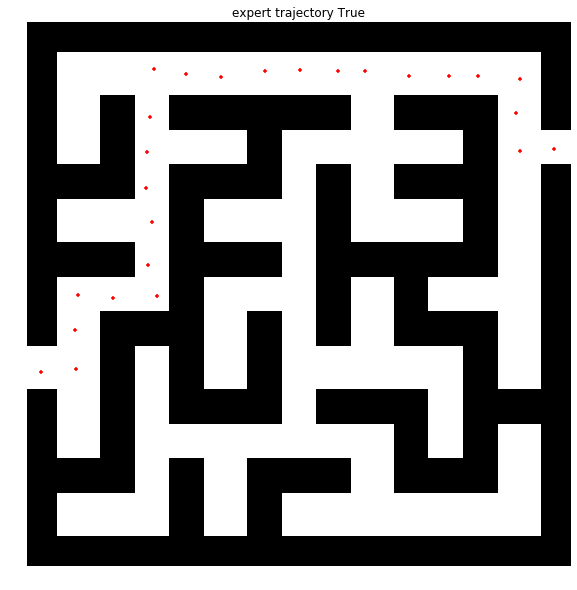

In [4]:
plot_solution(grid, solution)
plt.title('expert trajectory {}'.format(str(expert_flag)))

#### Plot data and losses

In [5]:
#play_raw_data(grid, solution)

In [6]:
#play_raw_data(goal, solution)

In [7]:
#play_raw_data(path, solution)

In [8]:
# Percentage of trajectories that are not valid
# This number roughly should be around 50%
# We did that to avoid biases during learning
# For each non valid trajectory we generate a valid trajectory
# This is controlled inside the functions
me.get_dopping_percentage_trajectories()

100%|██████████| 2200/2200 [00:04<00:00, 542.73it/s]

Estimated dopping percentage =  45.455


In [9]:
# The dopping percentage is at trajectory level
# It gives the number of trajectory points that are non valid
# This number is controled by alpha
me.get_dopping_percentage()

100%|██████████| 2200/2200 [00:13<00:00, 157.38it/s]

Estimated dopping percentage =  16.186


16.186

### Generate PyTorch dataset

In [10]:
# Unpacking one instance of our dataset
grid, path, goals, solution, expert_flag = me[400]
print('expert =', expert_flag)

## Grid: (64,64) maze grid
## Path: (64,64) shortest path grid
## Goals: (64,64) maze's start and end
## Solution: (X,2) maze's solution (variable lenght)

expert = False


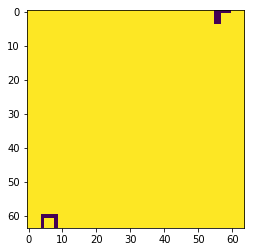

In [11]:
plt.imshow(draw_goals_canvas(grid, solution).T + goals)

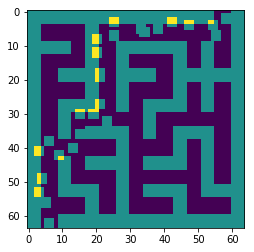

In [12]:
plt.imshow(draw_solution_canvas(grid, solution).T + grid)

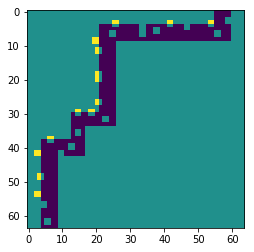

In [13]:
plt.imshow(draw_solution_canvas(path, solution).T + path)

#### Pytorch implementation of Graphic Loss (works only transposing the grid)

In [14]:
criterion = GraphicLoss()

In [15]:
criterion(torch.tensor(grid), torch.tensor(draw_solution_canvas(grid, solution)))

tensor(59)

In [16]:
criterion(torch.tensor(path), torch.tensor(draw_solution_canvas(path, solution)))

tensor(33)

In [17]:
criterion(torch.tensor(goals), torch.tensor(draw_goals_canvas(grid, solution)))

tensor(0)

In [18]:
rmse = RMSELoss()

In [19]:
rmse(torch.tensor(solution), torch.tensor(solution))

tensor(0.0000, dtype=torch.float64)

In [20]:
#def TotalLoss(target, prediction, expert_flag):
#    grid
if expert_flag:  #  imitation learning 
    loss = rmse(target, prediction)
else:  # random exploration
    # Calculate wall loss
    wall_loss = criterion(torch.tensor(grid), torch.tensor(draw_solution_canvas(grid, solution)))
    # Calculate shortest path loss / necessary 'wall loss' + 'path loss'
    path_loss = criterion(torch.tensor(path), torch.tensor(draw_solution_canvas(path, solution)))
    path_loss = abs(wall_loss-path_loss)
    # Calculate goals loss
    goal_loss = criterion(torch.tensor(goals), torch.tensor(draw_goals_canvas(grid, solution)))

    loss = wall_loss + path_loss + goal_loss

In [21]:
loss

tensor(85)

#### Numply implementation of Graphic Loss

In [22]:
print('Overlap loss solution and grid =', overlap_loss(draw_solution_canvas(grid, solution), grid))
print('Overlap loss  solution and path =',overlap_loss(draw_solution_canvas(grid, solution), path))
print('Overlap loss solution and goals =',overlap_loss(draw_goals_canvas(grid, solution), goals))

Overlap loss solution and grid = 59
Overlap loss  solution and path = 62
Overlap loss solution and goals = 0


#### Notes:
    1) We needed to transpose the grid to have a correct Loss calculation (Pytorch and Numpy).
    It that a data problem? Why?
    
    2) The value of path and grid losses are generally the same
    
    3) As the agent size is dynamic (road_size/2, road_size/2) losses are dependant on the road size.
    Each level of maze complexity has its own road_size. Low res mazes will be more punished.
    Shall we keep road size fixed?
    
    4) The max dopping size oftained is 15% with alpha=1. Is that sufficient to change the solution?
    Shall we create another definition to go beyond 15% dopping?
 
 ### Expert/non expert Loss calculation
     The Loss are calculating differently if the sample if 'expert' or non. 
         If expert:
             RMSE() + GraphicLoss() = RMSE() + 0 = RMSE()
         else:
             GraphicLoss()
             
     Both losses can be multiplied by a weight if necessary (if they are of different magnitude)

In [23]:
# Unpacking one instance of our dataset
grid, path, goals, solution, expert_flag = me[400]
print('expert =', expert_flag)

grid_expert, path_expert, goals_expert, solution_expert, expert_flag_expert = me[600]
print('expert =', expert_flag_expert)

expert = False
expert = True
